In [41]:
import pandas as pd
import numpy as np
from itertools import combinations

Load Dataset

In [42]:
def load_data(base_path):
    products = pd.read_csv(f"{base_path}/data/raw/products.csv")
    line_items = pd.read_csv(f"{base_path}/data/raw/store_sales_line_items.csv")

    merged = line_items.merge(products, on="product_id")
    return merged

In [43]:
import pandas as pd

BASE_PATH = r"D:\Shopping Basket affinity"

products = pd.read_csv(f"{BASE_PATH}/data/raw/products.csv")
sales_header = pd.read_csv(f"{BASE_PATH}/data/raw/store_sales_header.csv")
line_items = pd.read_csv(f"{BASE_PATH}/data/raw/store_sales_line_items.csv")

In [44]:
products.head()

,product_id,product_name,category
0,P001,Milk,Grocery
1,P002,Bread,Grocery
2,P003,Butter,Grocery
3,P004,Jam,Grocery
4,P005,Eggs,Grocery


In [45]:
products.shape

(16, 3)

In [46]:
products.isnull().sum()

product_id      0
product_name    0
category        0
dtype: int64

In [47]:
products.duplicated().sum()

np.int64(0)

In [48]:
sales_header.head()

,transaction_id,customer_id,transaction_date
0,T000001,C0655,2025-01-08
1,T000002,C0026,2025-02-17
2,T000003,C0282,2025-01-16
3,T000004,C0229,2025-01-09
4,T000005,C0755,2025-01-07


In [49]:
sales_header.shape

(5000, 3)

In [50]:
sales_header.isnull().sum()

transaction_id      0
customer_id         0
transaction_date    0
dtype: int64

In [51]:
line_items.head()

,transaction_id,product_id,quantity
0,T000001,P016,1
1,T000001,P015,2
2,T000002,P008,1
3,T000002,P006,2
4,T000002,P009,1


In [52]:
line_items.shape

(13678, 3)

Top 10 Most Purchased Products

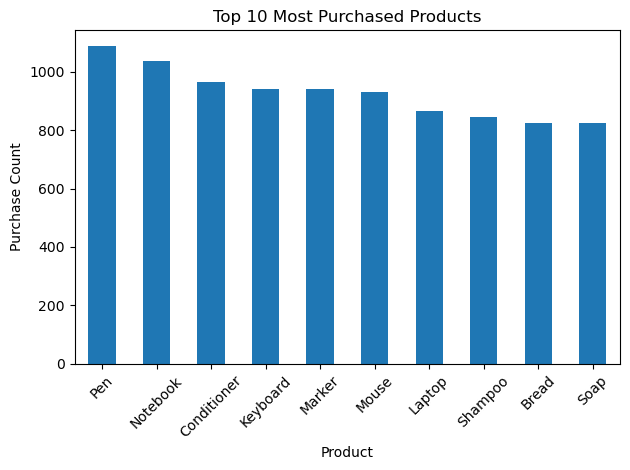

In [53]:
import matplotlib.pyplot as plt

product_counts = (
    line_items.merge(products, on="product_id")
    .groupby("product_name")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
product_counts.plot(kind="bar")
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Product")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Basket Size Distribution

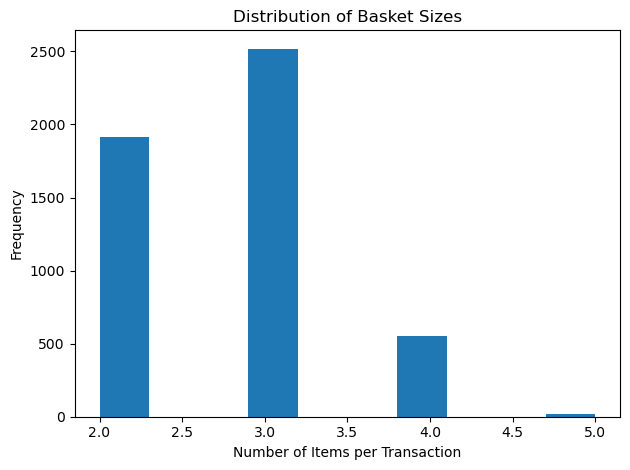

In [54]:
basket_sizes = line_items.groupby("transaction_id").size()

plt.figure()
basket_sizes.plot(kind="hist", bins=10)
plt.title("Distribution of Basket Sizes")
plt.xlabel("Number of Items per Transaction")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Build Transaction Baskets

In [55]:
def build_baskets(merged_df):
    baskets = (
        merged_df
        .groupby("transaction_id")["product_name"]
        .apply(list)
        .reset_index()
        .rename(columns={"product_name": "basket"})
    )
    return baskets


Generate Product Pairs

In [56]:
def generate_pairs(baskets_df):
    pairs = []

    for basket in baskets_df["basket"]:
        unique_items = set(basket)
        if len(unique_items) > 1:
            pairs.extend(combinations(sorted(unique_items), 2))

    return pd.Series(pairs)


Compute Support, Confidence & Lift

In [57]:
def compute_affinity_metrics(pairs, baskets_df):
    total_transactions = len(baskets_df)

    pair_counts = pairs.value_counts()

    item_counts = (
        baskets_df["basket"]
        .explode()
        .value_counts()
    )

    results = []

    for (item_a, item_b), pair_count in pair_counts.items():
        support = pair_count / total_transactions
        confidence = pair_count / item_counts[item_a]
        lift = confidence / (item_counts[item_b] / total_transactions)

        results.append({
            "product_A": item_a,
            "product_B": item_b,
            "support": round(support, 4),
            "confidence": round(confidence, 4),
            "lift": round(lift, 4)
        })

    return pd.DataFrame(results)


Filter & Rank Results

In [58]:
def get_top_affinities(
    affinity_df,
    min_support=0.01,
    min_confidence=0.1,
    top_k=10
):
    filtered = affinity_df[
        (affinity_df["support"] >= min_support) &
        (affinity_df["confidence"] >= min_confidence)
    ]

    return filtered.sort_values("lift", ascending=False).head(top_k)


End-to-End Runner

In [59]:
def run_affinity_pipeline(base_path):
    merged = load_data(base_path)
    baskets = build_baskets(merged)
    pairs = generate_pairs(baskets)
    affinity_df = compute_affinity_metrics(pairs, baskets)
    return affinity_df
